In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel('property_market_final.xlsx')

# 1. Próba wykonania modelu regresji liniowej dla mieszkań na sprzedaż w Warszawie

In [3]:
df = df[(df['City'] == 'Warszawa') & (df['Category'] == 'Sprzedaz')]

In [4]:
df

,City,District,Category,Property layout,Price,Negotiation,Sq_meters,Rooms,WebLink
7283,Warszawa,Wola,Sprzedaz,Kawalerka,480000.0,Brak możliwości negocjacji,31,1,https://www.olx.pl/d/oferta/przestronna-kawale...
7284,Warszawa,Śródmieście,Sprzedaz,Kawalerka,649000.0,Do negocjacji,31,1,https://www.olx.pl/d/oferta/mieszkanie-warszaw...
7285,Warszawa,Wawer,Sprzedaz,Kawalerka,350000.0,Brak możliwości negocjacji,29,1,https://www.olx.pl/d/oferta/tanio-kawalerka-mi...
7286,Warszawa,Targówek,Sprzedaz,Kawalerka,339900.0,Brak możliwości negocjacji,24,1,https://www.olx.plhttps://www.otodom.pl/pl/ofe...
7287,Warszawa,Mokotów,Sprzedaz,Kawalerka,459000.0,Do negocjacji,31,1,https://www.olx.pl/d/oferta/kawalerka-na-osied...
...,...,...,...,...,...,...,...,...,...
10099,Warszawa,Wawer,Sprzedaz,4-pokoje,599000.0,Brak możliwości negocjacji,75,4,https://www.olx.plhttps://www.otodom.pl/pl/ofe...
10100,Warszawa,Wawer,Sprzedaz,4-pokoje,619000.0,Brak możliwości negocjacji,120,4,https://www.olx.plhttps://www.otodom.pl/pl/ofe...
10101,Warszawa,Wawer,Sprzedaz,4-pokoje,920000.0,Brak możliwości negocjacji,127,4,https://www.olx.plhttps://www.otodom.pl/pl/ofe...
10102,Warszawa,Mokotów,Sprzedaz,4-pokoje,1629000.0,Brak możliwości negocjacji,85,4,https://www.olx.plhttps://www.otodom.pl/pl/ofe...


In [5]:
df = df.drop(['City','Category','WebLink'], axis='columns')

## Zmniejszenie liczby dzielnic

In [6]:
df['District'].value_counts()[:10]

District
Mokotów           386
Wola              304
Białołęka         299
Praga-Południe    225
Śródmieście       172
Ursynów           170
Bemowo            169
Bielany           154
Targówek          141
Ochota            128
Name: count, dtype: int64

In [7]:
df['District'].value_counts()[:10].sum()

2148

In [8]:
df['District'].value_counts()[10:]

District
Ursus           126
Włochy          121
Wawer           106
Wilanów          90
Żoliborz         83
Praga-Północ     76
Rembertów        26
Nie podano       23
Wesoła           21
Name: count, dtype: int64

In [9]:
df['District'].value_counts()[10:].sum()

672

In [10]:
district_low_offers = df['District'].value_counts()[10:].index

In [11]:
district_low_offers

Index(['Ursus', 'Włochy', 'Wawer', 'Wilanów', 'Żoliborz', 'Praga-Północ',
       'Rembertów', 'Nie podano', 'Wesoła'],
      dtype='object', name='District')

In [12]:
df['District'] = df['District'].apply(lambda x: 'Inne' if x in district_low_offers else x)

<Axes: xlabel='Sq_meters', ylabel='Price'>

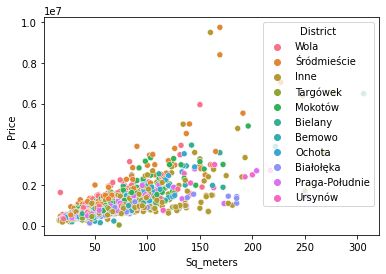

In [13]:
sns.scatterplot(data=df, x='Sq_meters',y='Price',hue='District')

In [14]:
df

,District,Property layout,Price,Negotiation,Sq_meters,Rooms
7283,Wola,Kawalerka,480000.0,Brak możliwości negocjacji,31,1
7284,Śródmieście,Kawalerka,649000.0,Do negocjacji,31,1
7285,Inne,Kawalerka,350000.0,Brak możliwości negocjacji,29,1
7286,Targówek,Kawalerka,339900.0,Brak możliwości negocjacji,24,1
7287,Mokotów,Kawalerka,459000.0,Do negocjacji,31,1
...,...,...,...,...,...,...
10099,Inne,4-pokoje,599000.0,Brak możliwości negocjacji,75,4
10100,Inne,4-pokoje,619000.0,Brak możliwości negocjacji,120,4
10101,Inne,4-pokoje,920000.0,Brak możliwości negocjacji,127,4
10102,Mokotów,4-pokoje,1629000.0,Brak możliwości negocjacji,85,4


## Unikamy współniniowości zmiennych

Property layout i Rooms opisują tą samą zmienną. 


In [15]:
df.drop(['Property layout'], axis='columns', inplace=True)

# 2. Model regresji 

In [16]:
outcome = df['Price']
predictors = df.drop('Price',axis='columns')
predictors = pd.get_dummies(predictors, drop_first=True, dtype=int)

In [17]:
house_lm = sm.OLS(outcome,predictors)
result = house_lm.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              1475.
Date:                Sat, 27 May 2023   Prob (F-statistic):                        0.00
Time:                        12:29:58   Log-Likelihood:                         -40338.
No. Observations:                2820   AIC:                                  8.070e+04
Df Residuals:                    2807   BIC:                                  8.078e+04
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

## Na poziomie istotności p = 5%
Usuwam zmienną dotyczącą Pragi południe 

In [18]:
predictors = predictors.drop('District_Praga-Południe',axis='columns')
predictors = pd.get_dummies(predictors, drop_first=True, dtype=int)

In [19]:
house_lm = sm.OLS(outcome,predictors)
result = house_lm.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              1598.
Date:                Sat, 27 May 2023   Prob (F-statistic):                        0.00
Time:                        12:29:58   Log-Likelihood:                         -40338.
No. Observations:                2820   AIC:                                  8.070e+04
Df Residuals:                    2808   BIC:                                  8.077e+04
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [20]:
#Ursynów 

In [21]:
predictors = predictors.drop('District_Ursynów',axis='columns')
predictors = pd.get_dummies(predictors, drop_first=True, dtype=int)

house_lm = sm.OLS(outcome,predictors)
result = house_lm.fit()
print(result.summary())


                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              1743.
Date:                Sat, 27 May 2023   Prob (F-statistic):                        0.00
Time:                        12:29:58   Log-Likelihood:                         -40339.
No. Observations:                2820   AIC:                                  8.070e+04
Df Residuals:                    2809   BIC:                                  8.076e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [22]:
#Bielany

In [23]:
predictors = predictors.drop('District_Bielany',axis='columns')
predictors = pd.get_dummies(predictors, drop_first=True, dtype=int)

house_lm = sm.OLS(outcome,predictors)
result = house_lm.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              1917.
Date:                Sat, 27 May 2023   Prob (F-statistic):                        0.00
Time:                        12:29:58   Log-Likelihood:                         -40339.
No. Observations:                2820   AIC:                                  8.070e+04
Df Residuals:                    2810   BIC:                                  8.076e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [24]:
#Negocjacja 

In [25]:
predictors = predictors.drop('Negotiation_Do negocjacji',axis='columns')
predictors = pd.get_dummies(predictors, drop_first=True, dtype=int)

house_lm = sm.OLS(outcome,predictors)
result = house_lm.fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Price   R-squared (uncentered):                   0.872
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              2129.
Date:                Sat, 27 May 2023   Prob (F-statistic):                        0.00
Time:                        12:29:59   Log-Likelihood:                         -40340.
No. Observations:                2820   AIC:                                  8.070e+04
Df Residuals:                    2811   BIC:                                  8.075e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Z modelu regresji wielorakiej usunięto zmienne: Negocjacja, Ursynów, Bielany i Praga-Południe. 

Na poziomie istotności p = 5% dla powyższych zmiennych przyjęta została H0: o braku istotności zmiennych na rzecz H1: O istotności zmiennej

## Diagnostyka wartości odstających w modelu  

In [26]:
influence = OLSInfluence(result)

Text(0, 0.5, 'STD RES')

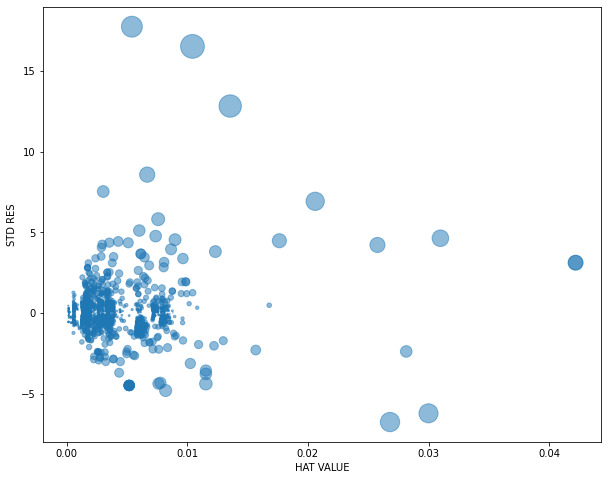

In [27]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(
    influence.hat_matrix_diag,
    influence.resid_studentized,
    s = 1000*np.sqrt(influence.cooks_distance[0]),
    alpha=0.5
)
ax.set_xlabel('HAT VALUE')
ax.set_ylabel('STD RES')

Wartości hat_value => wpływ punktu na równanie regresji 

STD_res => Punkt jest w granicach średniej ale odstaje od ogólnego trendu (punkty odpowiadające za poszerzenie danych) 

Odległosc Cooka => Miara wpływu obserwacji na dopasowanie modelu (D > 4/n -> wpływowa)

In [28]:
4/len(predictors)

0.0014184397163120568

In [29]:
df_corrected = pd.DataFrame({
    'hat':influence.hat_matrix_diag,
    'res':influence.resid_studentized,
    'cooks':influence.cooks_distance[0]
})

df_corrected = df_corrected[df_corrected['cooks']<= 4/len(predictors)]

Text(0, 0.5, 'STD RES')

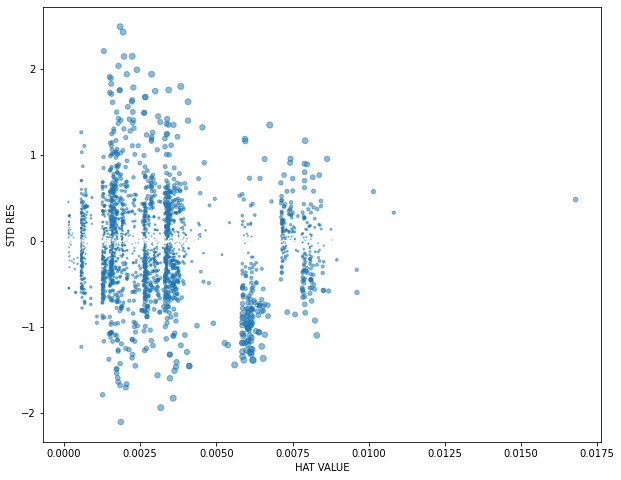

In [30]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(
    df_corrected['hat'],
    df_corrected['res'],
    s = 1000*np.sqrt(df_corrected['cooks']),
    alpha=0.5
)
ax.set_xlabel('HAT VALUE')
ax.set_ylabel('STD RES')

In [31]:
len(df_corrected)/len(influence.resid_studentized)

0.9549645390070922

In [32]:
df_corrected = df_corrected[(df_corrected['res']>=-2.5) & (df_corrected['res']<=2.5)]

In [33]:
len(df_corrected)/len(influence.resid_studentized)

0.9549645390070922

Text(0, 0.5, 'STD RES')

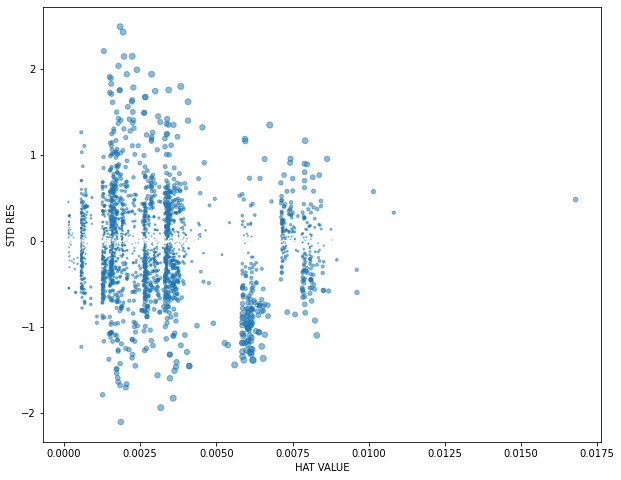

In [34]:
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(
    df_corrected['hat'],
    df_corrected['res'],
    s = 1000*np.sqrt(df_corrected['cooks']),
    alpha=0.5
)
ax.set_xlabel('HAT VALUE')
ax.set_ylabel('STD RES')

## Utworzenie modelu bez zmiennych zakłucających 

In [35]:
house_without_outll = predictors.loc[df_corrected.index]
huuse_price = outcome.loc[df_corrected.index]

In [36]:
house_no_outliers = sm.OLS(huuse_price, house_without_outll.assign(const=1))
result_no_outl = house_no_outliers.fit()
print(result_no_outl.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     917.3
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        12:29:59   Log-Likelihood:                -36655.
No. Observations:                2693   AIC:                         7.333e+04
Df Residuals:                    2683   BIC:                         7.339e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Sq_meters             1.728e+04 

In [37]:
house_without_outll.drop('District_Inne', axis='columns', inplace=True)

house_no_outliers = sm.OLS(huuse_price, house_without_outll.assign(const=1))
result_no_outl = house_no_outliers.fit()
print(result_no_outl.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1032.
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        12:29:59   Log-Likelihood:                -36656.
No. Observations:                2693   AIC:                         7.333e+04
Df Residuals:                    2684   BIC:                         7.338e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Sq_meters             1.728e+04 

# Heteroskedastyczność 
(sprawdzenie niestałości reszt na progrnozowanych wartościach)

<Axes: >

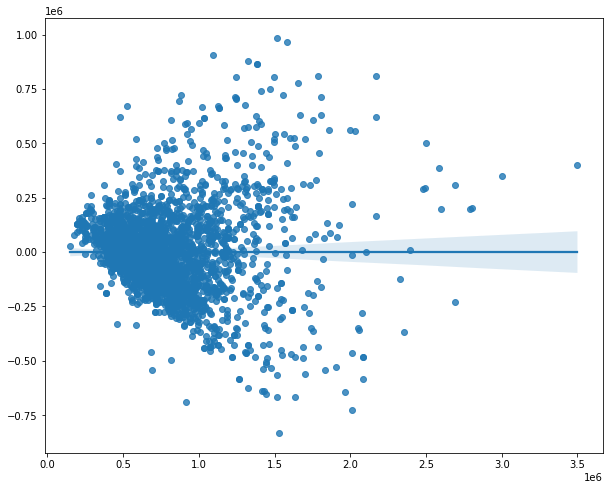

In [38]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=result_no_outl.fittedvalues,
            y=result_no_outl.resid,
           ax = ax)

In [39]:
house_without_outll.columns.values

array(['Sq_meters', 'Rooms', 'District_Białołęka', 'District_Mokotów',
       'District_Ochota', 'District_Targówek', 'District_Wola',
       'District_Śródmieście'], dtype=object)

In [40]:
from scipy import stats as s

In [41]:
data_join = pd.concat([huuse_price, house_without_outll], axis=1)

def homoscedasticity_chceck(data, price_number, out_name, pred_name):
    
    
    data_one = data[data[out_name]<=price_number]
    data_two = data[data[out_name]>=price_number]

    data_one_model = sm.OLS(data_one[out_name], data_one[pred_name].assign(const=1))
    result_one = data_one_model.fit()

    data_two_model = sm.OLS(data_two[out_name], data_two[pred_name].assign(const=1))
    result_two = data_two_model.fit()

    var_one = result_one.resid.var()
    var_two= result_two.resid.var()
    
    n1 = len(data_one) 
    n2 = len(data_two) 
    k = len(pred_name)
    
    F = ((n1-1)*(n2-k-1)*var_two)/((n2-1)*(n1-k-1)*var_one)
    
    df1 = n1-k-1
    df2 = n2-k-1
    p = 1 - s.f.cdf(F, df1,df2)
    print('p: ',p)
    if p < 0.05:
        print('Istnieje różnica istotna statystycznie miedzy zmiennymi')
    else:
        print('Brak różnic statystycznie istotnych')
    
    

In [42]:
homoscedasticity_chceck(data_join, 0.8e6, 'Price', house_without_outll.columns.values)

p:  1.1102230246251565e-16
Istnieje różnica istotna statystycznie miedzy zmiennymi


Model jest heteroskedastyczny, próbując przewidywać wartości mieszkań większych niż 0.5 mln model myli się w przewidywaniach i popełnia bardzo duże błędy 

Można spróbować dokonać transformacji modelu zmiennej wyjsciowej (Price i sprawdzić jak wpłynie to na hetersokedastycznośc) 

In [43]:
Price_log = np.log(huuse_price)
Price_sqrt = np.sqrt(huuse_price)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     920.4
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        12:30:00   Log-Likelihood:                 301.63
No. Observations:                2693   AIC:                            -585.3
Df Residuals:                    2684   BIC:                            -532.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Sq_meters                0.0151 

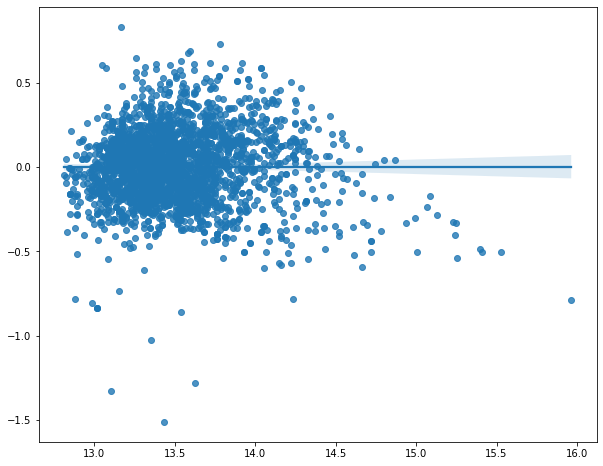

p:  0.00283092948215824
Istnieje różnica istotna statystycznie miedzy zmiennymi
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     1053.
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        12:30:00   Log-Likelihood:                -16130.
No. Observations:                2693   AIC:                         3.228e+04
Df Residuals:                    2684   BIC:                         3.233e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

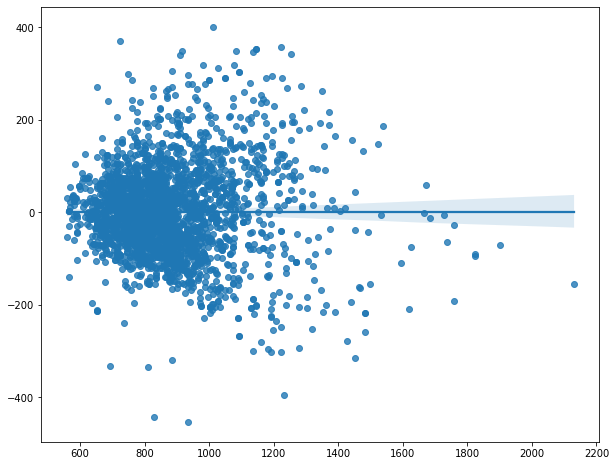

In [44]:
#Model z log
house_no_outliers = sm.OLS(Price_log, house_without_outll.assign(const=1))
result_no_outl = house_no_outliers.fit()
print(result_no_outl.summary())

fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=result_no_outl.fittedvalues,
            y=result_no_outl.resid,
           ax = ax)
plt.show()
data_join_log = pd.concat([Price_log, house_without_outll], axis=1)
homoscedasticity_chceck(data_join_log, 13.6, 'Price', house_without_outll.columns.values)


#Model z sqrt
house_no_outliers = sm.OLS(Price_sqrt, house_without_outll.assign(const=1))
result_no_outl = house_no_outliers.fit()
print(result_no_outl.summary())

fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=result_no_outl.fittedvalues,
            y=result_no_outl.resid,
           ax = ax)
data_join_sqrt = pd.concat([Price_sqrt, house_without_outll], axis=1)
homoscedasticity_chceck(data_join_sqrt, 1000, 'Price', house_without_outll.columns.values)

# 3. Podsumowanie 

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     920.4
Date:                Sat, 27 May 2023   Prob (F-statistic):               0.00
Time:                        12:30:00   Log-Likelihood:                 301.63
No. Observations:                2693   AIC:                            -585.3
Df Residuals:                    2684   BIC:                            -532.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Sq_meters                0.0151 

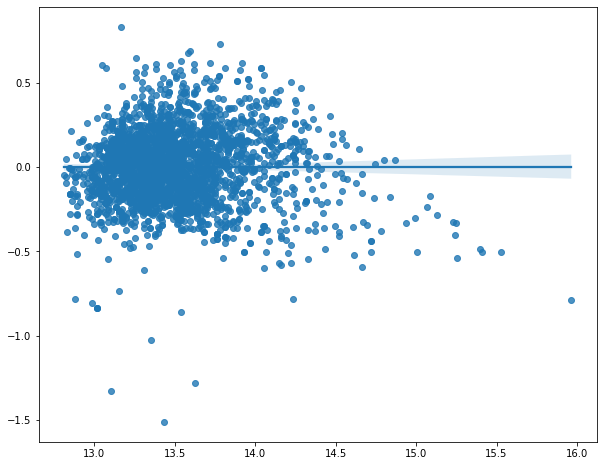

In [45]:
house_no_outliers = sm.OLS(Price_log, house_without_outll.assign(const=1))
result_no_outl = house_no_outliers.fit()
print(result_no_outl.summary())

fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=result_no_outl.fittedvalues,
            y=result_no_outl.resid,
           ax = ax)
plt.show()
data_join_log = pd.concat([Price_log, house_without_outll], axis=1)
#homoscedasticity_chceck(data_join_log, 13.6, 'Price', house_without_outll.columns.values)

###  1. Sporządzono model o współczynniku determinacji R2 = 0.73
Model regresji wyjaśnia zatem około 73% wartości 

### 2. Model przewiduje poprawnie wartości mieszkań uwzględniając tylko kilka dzielnic: 
* **Białołęka**

* **Mokotów**

* **Ochota**

* **Targówek**

* **Wola**

* **Śródmieście**


### 3.Model najlepiej sprawdza się na mniejszych mieszkaniach.

Wraz ze wzrostem powierzchni zwiększa sie błąd predykcji. (Model jest heteroskedastyczny)

Z tego względu kwoty zostały również przetransformowane do sklai logarytmicznej.  

## 4. Współczynniki 

In [46]:
result_no_outl.params

Sq_meters                0.015143
Rooms                    0.004019
District_Białołęka      -0.172689
District_Mokotów         0.193347
District_Ochota          0.111829
District_Targówek       -0.086582
District_Wola            0.225397
District_Śródmieście     0.355959
const                   12.586484
dtype: float64

Dla Białołęki i Targówka współczynniki są ujemne. Zatem wraz ze wrostem powierzchni i ilości pokoi kwota też będzie spadać. Być może w tych dzielniach jest parę wartości odstających, które zaburzają rozkład (np. sprzedawcy wpisywali swoje ogórdki działkowe jako mieszkania)